In [1]:
import numpy as np
import xarray as xr
from utility import util, load, analysis_parameters as ap
import matplotlib.pyplot as plt
import pandas as pd

In [2]:
MODEL = "NICAM"
REGION= "TWP"
cs=True

In [3]:
# functions
def get_total_water_path(model, region, print_on=False):
    """Returns total water path (fwp + lwp) in kg/m2."""
    print("fwp...")
    fwp = get_fwp(model, region)
    print(fwp.shape)
    print("lwp...")
    lwp = load.get_lwp(model, region, rain=True)
    if model=="ICON" or model=="FV3":
        lwp = lwp[11::12,:]
    elif model=="NICAM":
        lwp = lwp[11::12,0,:,:]   
    print(lwp.shape)
    print("total water path...")
    totwp = fwp + lwp
    return totwp

def get_fwp(model, region):
    """Returns total water path (fwp + lwp) in kg/m2."""
    print("fwp...")
    fwp = load.get_iwp(model, region, ice_only=False).values
    if model=="NICAM":
        fwp = fwp[11::12,0]
    elif model=="FV3": # model=="FV3" or "SAM":
        fwp = fwp[11::12]
    print(fwp.shape)
    return fwp

def get_olr_alb(model, region, return_const=False):
    olr, alb = load.get_olr_alb(model, region)
    print(olr.shape, alb.shape)
    if model=="ICON":
        if region=="TWP":
            alb = xr.DataArray(alb.values, dims=['time','cell'], coords={'time':alb.t.values, 'cell':alb.cell})
            olr = xr.DataArray(olr.values, dims=['time','cell'], coords={'time':olr.t.values,'cell':olr.cell})
        alb = alb[11::12,:]
        olr = olr[11::12,:]
    elif model=="NICAM":
        alb = alb[:,0,:,:]
        olr = olr[:,0,:,:]
    if model=="SAM":
        print(olr.shape, alb.shape)
        dummy_time = pd.date_range('2016-08-03 03:00:00', periods=304, freq="3H")
        alb = xr.DataArray(alb.values, dims=['time','lat','lon'],
                          coords={'time':dummy_time,'lat':alb.lat,'lon':alb.lon})
        olr = xr.DataArray(olr.values, dims=['time','lat','lon'],
                          coords={'time':dummy_time,'lat':alb.lat,'lon':alb.lon})
    print("restrict to near noontime...")
    if region=="TWP":
        alb = alb.where(alb.time.dt.hour<4)
        olr = olr.where(olr.time.dt.hour<4)
        const = 413.2335274 # W/m2 regional JAS insolation daily average
        print(alb.count())
    elif region=="SHL":
        alb = alb.where((alb.time.dt.hour>=9)&(alb.time.dt.hour<13))
        olr = olr.where((olr.time.dt.hour>=9)&(olr.time.dt.hour<13))
        const = 435.2760211 # W/m2 regional JAS insolation daily average
    elif region=="NAU":
        alb = alb.where((alb.time.dt.hour>=22)|(alb.time.dt.hour<2))
        olr = olr.where((olr.time.dt.hour>=22)|(olr.time.dt.hour<2))
        const = 413.2335274 # W/m2 regional JAS insolation daily average
    else: raise Exception("Use TWP, SHL, NAU for region.")
    if return_const:
        return olr, alb, const
    else:
        return olr, alb

def get_cs_frac(totwp,cs_thres=1e-4):
    """Returns fraction of total columns with clear sky (no liq or ice)."""
    num_cs = np.nansum(np.where(totwp<1e-4,1,0))
    frac_cs = num_cs/len(fwp.ravel())
    print("num: %s\nfrac:%s"%(num_cs, frac_cs))
    return frac_cs

def get_cs_num(totwp,cs_thres=1e-4):
    """Returns fraction of total columns with clear sky (no liq or ice)."""
    num_cs = np.nansum(np.where(totwp<1e-4,1,0))
    frac_cs = num_cs/len(fwp.ravel())
    print("num: %s\nfrac:%s"%(num_cs, frac_cs))
    return num_cs

def get_fwp_cat_freq(fwp):
    """Returns the cat freq as an pandas dataframe"""
    catfreq1 = np.sum(np.where(fwp>=1,1,0))/len(fwp.flatten())*100
    catfreq2 = np.sum(np.where((fwp>=1e-2)&(fwp<1),1,0))/len(fwp.flatten())*100
    catfreq3 = np.sum(np.where((fwp>=1e-4)&(fwp<1e-2),1,0))/len(fwp.flatten())*100
    csfreq = np.sum(np.where(fwp<1e-4,1,0))/len(fwp.flatten())*100
    print("CAT1: {}\nCAT2: {}\nCAT3: {}\nCS  : {}".format(catfreq1,catfreq2,catfreq3,csfreq))
    da = pd.DataFrame(np.array([catfreq1,catfreq2,catfreq3,csfreq]).T, 
                      index=["CAT1","CAT2","CAT3","CS"], 
                      columns=["freq"])
#     print(da)
    return da

def get_olr_alb_cat_med(fwp, model, region, olr, alb):
    print(alb.mean().values, alb.shape)
    print("compute categories...", alb.shape, fwp.shape)
    conv_thres, strat_thres, cs_thres = 1., 0.01, 1e-4
    alb1 = alb.where(fwp>=conv_thres).median().values
    alb2 = alb.where((fwp<conv_thres)&(fwp>=strat_thres)).median().values
    alb3 = alb.where((fwp<strat_thres)&(fwp>=cs_thres)).median().values
    print("... done with albedo...")
    olr1 = olr.where(fwp>=conv_thres).median().values
    olr2 = olr.where((fwp<conv_thres)&(fwp>=strat_thres)).median().values
    olr3 = olr.where((fwp<strat_thres)&(fwp>=cs_thres)).median().values
    print("... done with olr...")
    da = pd.DataFrame(np.array([[olr1,olr2,olr3],[alb1,alb2,alb3]]).T,
                      index=["CAT1","CAT2","CAT3"], columns=["OLR","ALB"])
#     print(da)
    return da

def get_olr_alb_cs_iso_ttl(totwp, ttliwp, model, region, olr, alb, cs_thres=1e-4, print_on=False):
    print("compute cs median values of olr and albedo...")
    print(alb.shape, totwp.shape, olr.shape)
    alb_cs = alb.where(totwp.values<cs_thres).median()
    olr_cs = olr.where(totwp.values<cs_thres).median()
    print(alb_cs, olr_cs)
    fwp_below_ttl = totwp.values - ttliwp
    alb_iso = alb.where((fwp_below_ttl<cs_thres)&(ttliwp>=cs_thres)).median()
    olr_iso = olr.where((fwp_below_ttl<cs_thres)&(ttliwp>=cs_thres)).median()
    print(alb_iso, olr_iso)
    da = pd.DataFrame(np.array([[olr_cs, olr_iso],[alb_cs, alb_iso]]).T,
                      index=["CS","ISO_TTL",], columns=["OLR","ALB"])
    isottl_freq = np.sum((fwp_below_ttl<cs_thres)&(ttliwp>=cs_thres))/len(ttliwp.flatten())
    print("... isolated ttl cirrus fraction...\n\t", isottl_freq)
    return isottl_freq, da

def get_ttl_olr_alb_cat(ttliwp, fwp, model, region, olr, alb, cs_thres=1e-4):
    """Returns ttl alb and olr median values for each fwp category."""
    conv_thres = 1
    strat_thres = 0.1
    ttlalb1 = alb.where((fwp>=conv_thres)&(ttliwp>cs_thres)).median().values
    ttlalb2 = alb.where((fwp<conv_thres)&(fwp>=strat_thres)&(ttliwp>cs_thres)).median().values
    ttlalb3 = alb.where((fwp<strat_thres)&(fwp>=cs_thres)&(ttliwp>cs_thres)).median().values
    ttlolr1 = olr.where((fwp>=conv_thres)&(ttliwp>=cs_thres)).median().values
    ttlolr2 = olr.where((fwp<conv_thres)&(fwp>=strat_thres)&(ttliwp>=cs_thres)).median().values
    ttlolr3 = olr.where((fwp<strat_thres)&(fwp>=cs_thres)&(ttliwp>=cs_thres)).median().values
    num = len(olr.values.flatten())
    ttlfreq1 = np.sum(((fwp>=conv_thres)&(ttliwp>=cs_thres)))/num
    ttlfreq2 = np.sum(((fwp<conv_thres)&(fwp>=strat_thres)&(ttliwp>=cs_thres)))/num
    ttlfreq3 = np.sum(((fwp<strat_thres)&(fwp>=cs_thres)&(ttliwp>=cs_thres)))/num
    da = pd.DataFrame(np.array([[ttlolr1, ttlolr2, ttlolr3],[ttlalb1, ttlalb2, ttlalb3],
                                [ttlfreq1, ttlfreq2, ttlfreq3]]).T,
                      index=["CAT1","CAT2","CAT3"], columns=["OLR_TTL","ALB_TTL", "TTL_FREQ"])
    return da

In [ ]:
%%time
# m, r = MODEL, REGION
MODELS=["FV3"] # ICON, NICAM and FV3 done
REGIONS=["TWP","SHL","NAU"] #"TWP","SHL",
for m in MODELS:
    for r in REGIONS:
        olr, alb = get_olr_alb(m, r)
        fwp = get_fwp(m, r)
        da_freq = get_fwp_cat_freq(fwp)
        da_olr_alb = get_olr_alb_cat_med(fwp,m,r,olr, alb)
        totwp = get_total_water_path(m,r)
        ttliwp = load.get_ttliwp(m,r).values
        print("ttliwp :", ttliwp.shape)
        ttl_alb_olr_cat = get_ttl_olr_alb_cat(ttliwp, fwp, m, r, olr, alb)
        isottl_freq, da_cs_isottl = get_olr_alb_cs_iso_ttl(totwp, ttliwp, m, r, olr, alb)
        df = pd.concat([pd.concat([da_freq,pd.concat([da_olr_alb,da_cs_isottl], axis=0)], 
                                  axis=1),ttl_alb_olr_cat], axis=1)
        df.freq.ISO_TTL = isottl_freq
        print(df)
        df.to_csv("../tables/{}_{}.csv".format(m,r))
        print("saved as ../tables/{}_{}.csv\n\n\n".format(m,r))

Getting olr and albedo for FV3 TWP:
(320, 342, 341) (304, 342, 341)
(304, 342, 341) (304, 342, 341)
restrict to near noontime...
<xarray.DataArray 'fsdt' ()>
array(8863272)
fwp...
... Getting fwp for FV3 in the TWP region ...


-------------------------
# Observations

In [10]:
twp_swu = xr.open_dataset(ap.CERES_TWP)["Outgoing SW radiation at TOA"]
twp_swd = xr.open_dataset(ap.CERES_TWP)["Incoming SW radiation at TOA"]
twp_olr = xr.open_dataset(ap.CERES_TWP)["Outgoing LW radiation at TOA"]
twp_iwp = xr.open_dataset(ap.CERES_TWP)["iwp MODIS"]

shl_swu = xr.open_dataset(ap.CERES_SHL)["Outgoing SW radiation at TOA"]
shl_swd = xr.open_dataset(ap.CERES_SHL)["Incoming SW radiation at TOA"]
shl_olr = xr.open_dataset(ap.CERES_SHL)["Outgoing LW radiation at TOA"]
shl_iwp = xr.open_dataset(ap.CERES_SHL)["iwp MODIS"]

nau_swu = xr.open_dataset(ap.CERES_NAU)["Outgoing SW radiation at TOA"]
nau_swd = xr.open_dataset(ap.CERES_NAU)["Incoming SW radiation at TOA"]
nau_olr = xr.open_dataset(ap.CERES_NAU)["Outgoing LW radiation at TOA"]
nau_iwp = xr.open_dataset(ap.CERES_NAU)["iwp MODIS"]

twp_alb = twp_swu/twp_swd
shl_alb = shl_swu/shl_swd
nau_alb = nau_swu/nau_swd

twp_iwc = xr.open_dataset(ap.CERES_TWP)["iwc used in CERES radiation, avg over cloudy part of CERES footprint"]
shl_iwc = xr.open_dataset(ap.CERES_SHL)["iwc used in CERES radiation, avg over cloudy part of CERES footprint"]
nau_iwc = xr.open_dataset(ap.CERES_NAU)["iwc used in CERES radiation, avg over cloudy part of CERES footprint"]
tz = twp_iwc.alt.values
sz = shl_iwc.alt.values
nz = nau_iwc.alt.values

t0, t1 = min(np.argmin(abs(tz-14)), np.argmin(abs(tz-18))), max(np.argmin(abs(tz-14)), np.argmin(abs(tz-18)))
s0, s1 = min(np.argmin(abs(sz-14)), np.argmin(abs(sz-18))), max(np.argmin(abs(sz-14)), np.argmin(abs(sz-18)))
n0, n1 = min(np.argmin(abs(nz-14)), np.argmin(abs(nz-18))), max(np.argmin(abs(nz-14)), np.argmin(abs(nz-18)))
print(tz[t0:t1], "\n", sz[s0:s1], "\n", nz[n0:n1])

twp_ttliwp = util.int_wrt_alt(twp_iwc[:,t0:t1]/1000, tz[t0:t1]*1000)
shl_ttliwp = util.int_wrt_alt(shl_iwc[:,s0:s1]/1000, sz[s0:s1]*1000)
nau_ttliwp = util.int_wrt_alt(nau_iwc[:,n0:n1]/1000, nz[n0:n1]*1000)



[18.       17.759998 17.52     17.279999 17.04     16.8      16.560001
 16.32     16.08     15.84     15.6      15.360001 15.12     14.88
 14.64     14.4      14.16    ] 
 [18.       17.759998 17.52     17.279999 17.04     16.8      16.560001
 16.32     16.08     15.84     15.6      15.360001 15.12     14.88
 14.64     14.4      14.16    ] 
 [18.       17.759998 17.52     17.279999 17.04     16.8      16.560001
 16.32     16.08     15.84     15.6      15.360001 15.12     14.88
 14.64     14.4      14.16    ]


In [11]:
twp_ttliwp.shape, twp_olr.shape, twp_alb.shape

((58273,), (58273,), (58273,))

In [12]:
twp_alb1 = twp_alb.where(twp_iwp>=1000)
twp_alb2 = twp_alb.where((twp_iwp>=10)&(twp_iwp<1000))
twp_alb3 = twp_alb.where((twp_iwp>=0.1)&(twp_iwp<10))
twp_albcld = twp_alb.where((twp_iwp>=0.1))
twp_albcs = twp_alb.where((twp_iwp<0.01))

shl_alb1 = shl_alb.where(shl_iwp>=1000)
shl_alb2 = shl_alb.where((shl_iwp>=10)&(shl_iwp<1000))
shl_alb3 = shl_alb.where((shl_iwp>=0.1)&(shl_iwp<10))
shl_albcld = shl_alb.where((shl_iwp>=0.1))
shl_albcs = shl_alb.where((shl_iwp<0.01))

nau_alb1 = nau_alb.where(nau_iwp>=1000)
nau_alb2 = nau_alb.where((nau_iwp>=10)&(nau_iwp<1000))
nau_alb3 = nau_alb.where((nau_iwp>=0.1)&(nau_iwp<10))
nau_albcld = nau_alb.where((nau_iwp>=0.1))
nau_albcs = nau_alb.where((nau_iwp<0.01))

twp_olr1 = twp_olr.where(twp_iwp>=1000)
twp_olr2 = twp_olr.where((twp_iwp>=10)&(twp_iwp<1000))
twp_olr3 = twp_olr.where((twp_iwp>=0.1)&(twp_iwp<10))
twp_olrcld = twp_olr.where((twp_iwp>=0.1))
twp_olrcs = twp_olr.where((twp_iwp<0.01))

shl_olr1 = shl_olr.where(shl_iwp>=1000)
shl_olr2 = shl_olr.where((shl_iwp>=10)&(shl_iwp<1000))
shl_olr3 = shl_olr.where((shl_iwp>=0.1)&(shl_iwp<10))
shl_olrcld = shl_olr.where((shl_iwp>=0.1))
shl_olrcs = shl_olr.where((shl_iwp<0.01))

nau_olr1 = nau_olr.where(nau_iwp>=1000)
nau_olr2 = nau_olr.where((nau_iwp>=10)&(nau_iwp<1000))
nau_olr3 = nau_olr.where((nau_iwp>=0.1)&(nau_iwp<10))
nau_olrcld = nau_olr.where((nau_iwp>=0.1))
nau_olrcs = nau_olr.where((nau_iwp<0.01))

In [13]:
twp_albttl1 = twp_alb1.where((twp_ttliwp>1e-4))
twp_albttl2 = twp_alb2.where((twp_ttliwp>1e-4))
twp_albttl3 = twp_alb3.where((twp_ttliwp>1e-4))

twp_olrttl1 = twp_olr1.where((twp_ttliwp>1e-4))
twp_olrttl2 = twp_olr2.where((twp_ttliwp>1e-4))
twp_olrttl3 = twp_olr3.where((twp_ttliwp>1e-4))

shl_albttl1 = shl_alb1.where((shl_ttliwp>1e-4))
shl_albttl2 = shl_alb2.where((shl_ttliwp>1e-4))
shl_albttl3 = shl_alb3.where((shl_ttliwp>1e-4))

shl_olrttl1 = shl_olr1.where((shl_ttliwp>1e-4))
shl_olrttl2 = shl_olr2.where((shl_ttliwp>1e-4))
shl_olrttl3 = shl_olr3.where((shl_ttliwp>1e-4))

nau_albttl1 = nau_alb1.where((nau_ttliwp>1e-4))
nau_albttl2 = nau_alb2.where((nau_ttliwp>1e-4))
nau_albttl3 = nau_alb3.where((nau_ttliwp>1e-4))

nau_olrttl1 = nau_olr1.where((nau_ttliwp>1e-4))
nau_olrttl2 = nau_olr2.where((nau_ttliwp>1e-4))
nau_olrttl3 = nau_olr3.where((nau_ttliwp>1e-4))


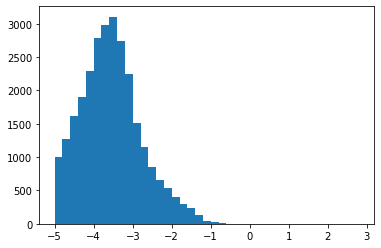

In [14]:
plt.hist(np.log10(twp_ttliwp.flatten()), bins=np.arange(-5,3,0.2))
plt.show()

In [15]:
t_ttl1 = np.sum(np.where((twp_iwp>=1000)&(twp_ttliwp>1e-4),1,0))
t_ttl2 = np.sum(np.where((twp_iwp>=10)&(twp_iwp<1000)&(twp_ttliwp>1e-4),1,0))
t_ttl3 = np.sum(np.where((twp_iwp>=0.1)&(twp_iwp<10)&(twp_ttliwp>1e-4),1,0))
t_1 = np.sum(np.where((twp_iwp>=1000),1,0))
t_2 = np.sum(np.where((twp_iwp<1000)&(twp_iwp>=10),1,0))
t_3 = np.sum(np.where((twp_iwp<10)&(twp_iwp>=0.1),1,0))

s_ttl1 = np.sum(np.where((shl_iwp>=1000)&(shl_ttliwp>1e-4),1,0))
s_ttl2 = np.sum(np.where((shl_iwp>=10)&(shl_iwp<1000)&(shl_ttliwp>1e-4),1,0))
s_ttl3 = np.sum(np.where((shl_iwp>=0.1)&(shl_iwp<10)&(shl_ttliwp>1e-4),1,0))
s_1 = np.sum(np.where((shl_iwp>=1000),1,0))
s_2 = np.sum(np.where((shl_iwp<1000)&(shl_iwp>=10),1,0))
s_3 = np.sum(np.where((shl_iwp<10)&(shl_iwp>=0.1),1,0))

n_ttl1 = np.sum(np.where((nau_iwp>=1000)&(nau_ttliwp>1e-4),1,0))
n_ttl2 = np.sum(np.where((nau_iwp>=10)&(nau_iwp<1000)&(nau_ttliwp>1e-4),1,0))
n_ttl3 = np.sum(np.where((nau_iwp>=0.1)&(nau_iwp<10)&(nau_ttliwp>1e-4),1,0))
n_1 = np.sum(np.where((nau_iwp>=1000),1,0))
n_2 = np.sum(np.where((nau_iwp<1000)&(nau_iwp>=10),1,0))
n_3 = np.sum(np.where((nau_iwp<10)&(nau_iwp>=0.1),1,0))

print("\nTWP:")
print("Percent in TTL (abs):\n",t_ttl1/len(twp_ttliwp.flatten())*100,"\n",
     t_ttl2/len(twp_ttliwp.flatten())*100, "\n", t_ttl3/len(twp_ttliwp.flatten())*100)
print("\nPercent in TTL (rel):\n",t_ttl1/t_1*100,"\n",
     t_ttl2/t_2*100, "\n", t_ttl3/t_3*100)

print("\n\nSHL:")
print("Percent in TTL (abs):\n",s_ttl1/len(shl_ttliwp.flatten())*100,"\n",
     s_ttl2/len(shl_ttliwp.flatten())*100, "\n", s_ttl3/len(shl_ttliwp.flatten())*100)
print("\nPercent in TTL (rel):\n",s_ttl1/s_1*100,"\n",
     s_ttl2/s_2*100, "\n", s_ttl3/s_3*100)

print("\n\nNAU:")
print("Percent in TTL (abs):\n",n_ttl1/len(nau_ttliwp.flatten())*100,"\n",
     n_ttl2/len(nau_ttliwp.flatten())*100, "\n", n_ttl3/len(nau_ttliwp.flatten())*100)
print("\nPercent in TTL (rel):\n",n_ttl1/n_1*100,"\n",
     n_ttl2/n_2*100, "\n", n_ttl3/n_3*100)


TWP:
Percent in TTL (abs):
 1.9013951572769552 
 23.834365829801108 
 8.10495426698471

Percent in TTL (rel):
 88.14638027048528 
 49.47987174919844 
 22.077315009582573


SHL:
Percent in TTL (abs):
 0.6458055925432756 
 11.418109187749668 
 2.9960053262316912

Percent in TTL (rel):
 70.8029197080292 
 31.642066420664207 
 7.8753937696884835


NAU:
Percent in TTL (abs):
 0.5451360688072879 
 6.862389166894353 
 2.353273623498677

Percent in TTL (rel):
 65.74136763710223 
 23.965753872295927 
 8.24979662529194


In [16]:
print("\nTWP CAT:")
print("Percent:\n",t_ttl1/len(twp_ttliwp.flatten())*100,"\n",
     t_ttl2/len(twp_ttliwp.flatten())*100, "\n", t_ttl3/len(twp_ttliwp.flatten())*100)

print("\nSHL:")
print("Percent:\n",s_ttl1/len(shl_ttliwp.flatten())*100,"\n",
     s_ttl2/len(shl_ttliwp.flatten())*100, "\n", s_ttl3/len(shl_ttliwp.flatten())*100)

print("\nNAU:")
print("Percent:\n",n_ttl1/len(nau_ttliwp.flatten())*100,"\n",
     n_ttl2/len(nau_ttliwp.flatten())*100, "\n", n_ttl3/len(nau_ttliwp.flatten())*100)


TWP CAT:
Percent:
 1.9013951572769552 
 23.834365829801108 
 8.10495426698471

SHL:
Percent:
 0.6458055925432756 
 11.418109187749668 
 2.9960053262316912

NAU:
Percent:
 0.5451360688072879 
 6.862389166894353 
 2.353273623498677


In [17]:
print("Tot Col:\nTWP alb median:")
print(np.nanmedian(twp_alb1))
print(np.nanmedian(twp_alb2))
print(np.nanmedian(twp_alb3))
print(np.nanmedian(twp_albcs))

print("\nSHL alb med:")
print(np.nanmedian(shl_alb1))
print(np.nanmedian(shl_alb2))
print(np.nanmedian(shl_alb3))
print(np.nanmedian(shl_albcs))

print("\nNAU alb median:")
print(np.nanmedian(nau_alb1))
print(np.nanmedian(nau_alb2))
print(np.nanmedian(nau_alb3))
print(np.nanmedian(nau_albcs))

print("\nTWP olr median:")
print(np.nanmedian(twp_olr1))
print(np.nanmedian(twp_olr2))
print(np.nanmedian(twp_olr3))
print(np.nanmedian(twp_olrcs))

print("\nSHL olr med:")
print(np.nanmedian(shl_olr1))
print(np.nanmedian(shl_olr2))
print(np.nanmedian(shl_olr3))
print(np.nanmedian(shl_olrcs))

print("\nNAU olr median:")
print(np.nanmedian(nau_olr1))
print(np.nanmedian(nau_olr2))
print(np.nanmedian(nau_olr3))
print(np.nanmedian(nau_olrcs))




Tot Col:
TWP alb median:
0.6282219
0.28398657
0.094029404
0.06791401

SHL alb med:
0.6324635
0.35784465
0.24678075
0.24016908

NAU alb median:
0.6194838
0.29456803
0.123807155
0.0676983

TWP olr median:
105.45
195.325
262.1
278.84998

SHL olr med:
111.675
201.425
258.175
291.5125

NAU olr median:
113.425
205.175
264.475
281.85


In [18]:
print("TTL Properties:\nTWP albttl median:")
print(np.nanmedian(twp_albttl1))
print(np.nanmedian(twp_albttl2))
print(np.nanmedian(twp_albttl3))

print("\nSHL albttl med:")
print(np.nanmedian(shl_albttl1))
print(np.nanmedian(shl_albttl2))
print(np.nanmedian(shl_albttl3))

print("\nNAU albttl median:")
print(np.nanmedian(nau_albttl1))
print(np.nanmedian(nau_albttl2))
print(np.nanmedian(nau_albttl3))

print("\nTWP olrttl median:")
print(np.nanmedian(twp_olrttl1))
print(np.nanmedian(twp_olrttl2))
print(np.nanmedian(twp_olrttl3))

print("\nSHL olrttl med:")
print(np.nanmedian(shl_olrttl1))
print(np.nanmedian(shl_olrttl2))
print(np.nanmedian(shl_olrttl3))

print("\nNAU olrttl median:")
print(np.nanmedian(nau_olrttl1))
print(np.nanmedian(nau_olrttl2))
print(np.nanmedian(nau_olrttl3))


TTL Properties:
TWP albttl median:
0.6341328
0.32666507
0.099572465

SHL albttl med:
0.6395956
0.39041573
0.24317974

NAU albttl median:
0.6332389
0.331793
0.103648126

TWP olrttl median:
102.725
168.525
250.2

SHL olrttl med:
107.5
163.575
233.575

NAU olrttl median:
106.775
169.3
252.95


In [19]:
print("cloudy sky albedo median: (TWP, SHL, NAU)")
print(np.nanmedian(twp_albcld))
print(np.nanmedian(shl_albcld))
print(np.nanmedian(nau_albcld))

print("Cldy alb mean: (TWP, SHL, NAU)")
print(np.nanmean(twp_albcld), "\n",np.nanmean(shl_albcld), "\n",np.nanmean(nau_albcld))

print("Cldy alb std: (TWP, SHL, NAU)")
print(np.nanstd(twp_albcld), "\n", np.nanstd(shl_albcld), "\n", np.nanstd(nau_albcld))

cloudy sky albedo median: (TWP, SHL, NAU)
0.16709378
0.26468813
0.18947846
Cldy alb mean: (TWP, SHL, NAU)
0.23254909 
 0.29490632 
 0.23116246
Cldy alb std: (TWP, SHL, NAU)
0.16736227 
 0.10221893 
 0.14650501


In [20]:
import pandas as pd
ttot = len(twp_olr.values.flatten())
stot = len(shl_olr.values.flatten())
ntot = len(nau_olr.values.flatten())
d = {'twp_catfreq':[t_1/ttot,t_2/ttot,t_3/ttot,1-(t_1+t_2+t_3)/ttot],
     'twp_catfreq_ttl':[t_ttl1/ttot,t_ttl2/ttot,t_ttl3/ttot,np.nan],
     'twp_ttlcatfreq':[t_ttl1/t_1,t_ttl2/t_2,t_ttl3/t_3,np.nan],
     'twp_olr_med':[abs(twp_olr1.median().values),abs(twp_olr2.median().values),
                abs(twp_olr3.median().values),abs(twp_olrcs.median().values)],
     'twp_alb_med':[twp_alb1.median().values,twp_alb2.median().values,
                twp_alb3.median().values,twp_albcs.median().values],
     'twp_olr_ttl':[abs(twp_olrttl1.median().values),abs(twp_olrttl2.median().values),
                abs(twp_olrttl3.median().values),np.nan],
     'twp_alb_ttl':[twp_albttl1.median().values,twp_albttl2.median().values,
                    twp_albttl3.median().values,np.nan],
     'shl_catfreq':[s_1/stot,s_2/stot,s_3/stot,1-(s_1+s_2+s_3)/stot],
     'shl_catfreq_ttl':[s_ttl1/stot,s_ttl2/stot,s_ttl3/stot,np.nan],
     'shl_ttlcatfreq':[s_ttl1/s_1,s_ttl2/s_2,s_ttl3/s_3,np.nan],
     'shl_olr_med':[abs(shl_olr1.median().values),abs(shl_olr2.median().values),
                abs(shl_olr3.median().values),abs(shl_olrcs.median().values)],
     'shl_alb_med':[shl_alb1.median().values,shl_alb2.median().values,
                shl_alb3.median().values,shl_albcs.median().values],
     'shl_olr_ttl':[abs(shl_olrttl1.median().values),abs(shl_olrttl2.median().values),
                abs(shl_olrttl3.median().values),np.nan],
     'shl_alb_ttl':[shl_albttl1.median().values,shl_albttl2.median().values,
                    shl_albttl3.median().values,np.nan],
     'nau_catfreq':[n_1/ntot,n_2/ntot,n_3/ntot,1-(n_1+n_2+n_3)/ntot],
     'nau_catfreq_ttl':[n_ttl1/ntot,n_ttl2/ntot,n_ttl3/ntot,np.nan],
     'nau_ttlcatfreq':[n_ttl1/n_1,n_ttl2/n_2,n_ttl3/n_3,np.nan],
     'nau_olr_med':[abs(nau_olr1.median().values),abs(nau_olr2.median().values),
                abs(nau_olr3.median().values),abs(nau_olrcs.median().values)],
     'nau_alb_med':[nau_alb1.median().values,nau_alb2.median().values,
                nau_alb3.median().values,nau_albcs.median().values],
     'nau_olr_ttl':[abs(nau_olrttl1.median().values),abs(nau_olrttl2.median().values),
                abs(nau_olrttl3.median().values),np.nan],
     'nau_alb_ttl':[nau_albttl1.median().values,nau_albttl2.median().values,
                    nau_albttl3.median().values,np.nan]
    }
df = pd.DataFrame(d,index=['CAT1','CAT2','CAT3','CS'])
df

,twp_catfreq,twp_catfreq_ttl,twp_ttlcatfreq,twp_olr_med,twp_alb_med,twp_olr_ttl,twp_alb_ttl,shl_catfreq,shl_catfreq_ttl,shl_ttlcatfreq,...,shl_alb_med,shl_olr_ttl,shl_alb_ttl,nau_catfreq,nau_catfreq_ttl,nau_ttlcatfreq,nau_olr_med,nau_alb_med,nau_olr_ttl,nau_alb_ttl
CAT1,0.021571,0.019014,0.881464,105.449997,0.6282219290733337,102.724998,0.6341328024864197,0.009121,0.006458,0.708029,...,0.6324635148048401,107.500000,0.639595627784729,0.008292,0.005451,0.657414,113.425003,0.6194838285446167,106.775002,0.6332389116287231
CAT2,0.481698,0.238344,0.494799,195.324997,0.28398656845092773,168.524994,0.32666507363319397,0.360852,0.114181,0.316421,...,0.35784465074539185,163.574997,0.3904157280921936,0.286341,0.068624,0.239658,205.175003,0.2945680320262909,169.300003,0.33179301023483276
CAT3,0.367117,0.081050,0.220773,262.100006,0.09402940422296524,250.199997,0.09957246482372284,0.380426,0.029960,0.078754,...,0.24678075313568115,233.574997,0.24317973852157593,0.285252,0.023533,0.082498,264.475006,0.1238071545958519,252.949997,0.1036481261253357
CS,0.129614,NaN,NaN,278.849976,0.06791400909423828,NaN,NaN,0.249601,NaN,NaN,...,0.24016907811164856,NaN,NaN,0.420114,NaN,NaN,281.850006,0.06769829988479614,NaN,NaN


In [21]:
d_twp = {'freq':[t_1/ttot,t_2/ttot,t_3/ttot,1-(t_1+t_2+t_3)/ttot],
     'TTL_FREQ':[t_ttl1/ttot,t_ttl2/ttot,t_ttl3/ttot,np.nan],
     'OLR':[abs(twp_olr1.median().values),abs(twp_olr2.median().values),
                abs(twp_olr3.median().values),abs(twp_olrcs.median().values)],
     'ALB':[twp_alb1.median().values,twp_alb2.median().values,
                twp_alb3.median().values,twp_albcs.median().values],
     'OLR_TTL':[abs(twp_olrttl1.median().values),abs(twp_olrttl2.median().values),
                abs(twp_olrttl3.median().values),np.nan],
     'ALB_TTL':[twp_albttl1.median().values,twp_albttl2.median().values,
                    twp_albttl3.median().values,np.nan]}

In [22]:
d_shl = {'freq':[s_1/stot,s_2/stot,s_3/stot,1-(s_1+s_2+s_3)/stot],
     'TTL_FREQ':[s_ttl1/stot,s_ttl2/stot,s_ttl3/stot,np.nan],
     'OLR':[abs(shl_olr1.median().values),abs(shl_olr2.median().values),
                abs(shl_olr3.median().values),abs(shl_olrcs.median().values)],
     'ALB':[shl_alb1.median().values,shl_alb2.median().values,
                shl_alb3.median().values,shl_albcs.median().values],
     'OLR_TTL':[abs(shl_olrttl1.median().values),abs(shl_olrttl2.median().values),
                abs(shl_olrttl3.median().values),np.nan],
     'ALB_TTL':[shl_albttl1.median().values,shl_albttl2.median().values,
                    shl_albttl3.median().values,np.nan]}

In [23]:
d_nau = {'catfreq':[n_1/ntot,n_2/ntot,n_3/ntot,1-(n_1+n_2+n_3)/ntot],
     'catfreq_ttl':[n_ttl1/ntot,n_ttl2/ntot,n_ttl3/ntot,np.nan],
     'OLR':[abs(nau_olr1.median().values),abs(nau_olr2.median().values),
                abs(nau_olr3.median().values),abs(nau_olrcs.median().values)],
     'ALB':[nau_alb1.median().values,nau_alb2.median().values,
                nau_alb3.median().values,nau_albcs.median().values],
     'OLR_TTL':[abs(nau_olrttl1.median().values),abs(nau_olrttl2.median().values),
                abs(nau_olrttl3.median().values),np.nan],
     'ALB_TTL':[nau_albttl1.median().values,nau_albttl2.median().values,
                    nau_albttl3.median().values,np.nan]}

In [25]:
df_twp = pd.DataFrame(d_twp, index=["CAT1","CAT2","CAT3","CS"])
df_shl = pd.DataFrame(d_shl, index=["CAT1","CAT2","CAT3","CS"])
df_nau = pd.DataFrame(d_nau, index=["CAT1","CAT2","CAT3","CS"])

In [26]:
df_twp.to_csv("../tables/CCCM_TWP_new.csv")
df_shl.to_csv("../tables/CCCM_SHL.csv")
df_nau.to_csv("../tables/CCCM_NAU.csv")

# DARDAR

In [52]:
tiwp = xr.open_dataset(ap.DARDAR_TWP)["iwp"]
siwp = xr.open_dataset(ap.DARDAR_SHL)["iwp"]
niwp = xr.open_dataset(ap.DARDAR_NAU)["iwp"]

tiwc = xr.open_dataset(ap.DARDAR_TWP)["iwc"]
siwc = xr.open_dataset(ap.DARDAR_SHL)["iwc"]
niwc = xr.open_dataset(ap.DARDAR_NAU)["iwc"]

tz = tiwc.height.values
sz = siwc.height.values
nz = niwc.height.values

t0, t1 = min(np.argmin(abs(tz-14000)), np.argmin(abs(tz-18000))), max(np.argmin(abs(tz-14000)), np.argmin(abs(tz-18000)))
s0, s1 = min(np.argmin(abs(sz-14000)), np.argmin(abs(sz-18000))), max(np.argmin(abs(sz-14000)), np.argmin(abs(sz-18000)))
n0, n1 = min(np.argmin(abs(nz-14000)), np.argmin(abs(nz-18000))), max(np.argmin(abs(nz-14000)), np.argmin(abs(nz-18000)))
# print(tz[t0:t1], "\n", sz[s0:s1], "\n", nz[n0:n1])

t_ttliwp = util.int_wrt_alt(tiwc[:,t0:t1]/1000, tz[t0:t1])*1000
s_ttliwp = util.int_wrt_alt(siwc[:,s0:s1]/1000, sz[s0:s1])*1000
n_ttliwp = util.int_wrt_alt(niwc[:,n0:n1]/1000, nz[n0:n1])*1000

t_bel = util.int_wrt_alt(tiwc[:,t1:]/1000, tz[t1:])*1000
s_bel = util.int_wrt_alt(siwc[:,s1:]/1000, sz[s1:])*1000
n_bel = util.int_wrt_alt(niwc[:,n1:]/1000, nz[n1:])*1000


In [58]:
np.sum(np.where((t_bel<0.1)&(t_ttliwp>=0.1),1,0))

7465

In [59]:
t_ttl1 = np.sum(np.where((tiwp>=1000)&(t_ttliwp>0),1,0))
t_ttl2 = np.sum(np.where((tiwp>=10)&(tiwp<1000)&(t_ttliwp>0),1,0))
t_ttl3 = np.sum(np.where((tiwp>=0.1)&(tiwp<10)&(t_ttliwp>0),1,0))
t_1 = np.sum(np.where((tiwp>=1000),1,0))
t_2 = np.sum(np.where((tiwp<1000)&(tiwp>=10),1,0))
t_3 = np.sum(np.where((tiwp<10)&(tiwp>=0.1),1,0))

s_ttl1 = np.sum(np.where((siwp>=1000)&(s_ttliwp>0),1,0))
s_ttl2 = np.sum(np.where((siwp>=10)&(siwp<1000)&(s_ttliwp>0),1,0))
s_ttl3 = np.sum(np.where((siwp>=0.1)&(siwp<10)&(s_ttliwp>0),1,0))
s_1 = np.sum(np.where((siwp>=1000),1,0))
s_2 = np.sum(np.where((siwp<1000)&(siwp>=10),1,0))
s_3 = np.sum(np.where((siwp<10)&(siwp>=0.1),1,0))

n_ttl1 = np.sum(np.where((niwp>=1000)&(n_ttliwp>0),1,0))
n_ttl2 = np.sum(np.where((niwp>=10)&(niwp<1000)&(n_ttliwp>0),1,0))
n_ttl3 = np.sum(np.where((niwp>=0.1)&(niwp<10)&(n_ttliwp>0),1,0))
n_1 = np.sum(np.where((niwp>=1000),1,0))
n_2 = np.sum(np.where((niwp<1000)&(niwp>=10),1,0))
n_3 = np.sum(np.where((niwp<10)&(niwp>=0.1),1,0))

t_iso = np.sum(np.where((t_bel<0.1)&(t_ttliwp>=0.1),1,0))
s_iso = np.sum(np.where((s_bel<0.1)&(s_ttliwp>=0.1),1,0))
n_iso = np.sum(np.where((n_bel<0.1)&(n_ttliwp>=0.1),1,0))

print("\nt CAT:")
print("Percent:\n",t_1/len(t_ttliwp.flatten())*100,"\n",
     t_2/len(t_ttliwp.flatten())*100, "\n", t_3/len(t_ttliwp.flatten())*100)

print("\ns:")
print("Percent:\n",s_1/len(s_ttliwp.flatten())*100,"\n",
     s_2/len(s_ttliwp.flatten())*100, "\n", s_3/len(s_ttliwp.flatten())*100)

print("\nn:")
print("Percent:\n",n_1/len(n_ttliwp.flatten())*100,"\n",
     n_2/len(n_ttliwp.flatten())*100, "\n", n_3/len(n_ttliwp.flatten())*100)


print("\nt:")
print("Percent in TTL (abs):\n",t_ttl1/len(t_ttliwp.flatten())*100,"\n",
     t_ttl2/len(t_ttliwp.flatten())*100, "\n", t_ttl3/len(t_ttliwp.flatten())*100)
print("\nPercent in TTL (rel):\n",t_ttl1/t_1*100,"\n",
     t_ttl2/t_2*100, "\n", t_ttl3/t_3*100)

print("\n\ns:")
print("Percent in TTL (abs):\n",s_ttl1/len(s_ttliwp.flatten())*100,"\n",
     s_ttl2/len(s_ttliwp.flatten())*100, "\n", s_ttl3/len(s_ttliwp.flatten())*100)
print("\nPercent in TTL (rel):\n",s_ttl1/s_1*100,"\n",
     s_ttl2/s_2*100, "\n", s_ttl3/s_3*100)

print("\n\nn:")
print("Percent in TTL (abs):\n",n_ttl1/len(n_ttliwp.flatten())*100,"\n",
     n_ttl2/len(n_ttliwp.flatten())*100, "\n", n_ttl3/len(n_ttliwp.flatten())*100)
print("\nPercent in TTL (rel):\n",n_ttl1/n_1*100,"\n",
     n_ttl2/n_2*100, "\n", n_ttl3/n_3*100)

print("\nt Iolated TTL cirrus fraction:")
print("Percent:\n",t_iso/len(t_ttliwp.flatten())*100,"\n")

print("\ns:")
print("Percent:\n",s_iso/len(s_ttliwp.flatten())*100,"\n")

print("\nn:")
print("Percent:\n",n_iso/len(n_ttliwp.flatten())*100,"\n")



t CAT:
Percent:
 10.940430226144512 
 48.10535024820739 
 25.406784335355763

s:
Percent:
 3.7128445811080537 
 28.27183470896046 
 30.50790311269353

n:
Percent:
 8.845963745174261 
 41.622249829679795 
 27.105625242121857

t:
Percent in TTL (abs):
 9.237451737451737 
 38.04467733039162 
 18.025372311086596

Percent in TTL (rel):
 84.43408116964962 
 79.0861663704638 
 70.94708276797829


s:
Percent in TTL (abs):
 3.0155904407401413 
 21.057884231536928 
 20.398392404380427

Percent in TTL (rel):
 81.22048674173628 
 74.48361398654772 
 66.86264975023208


n:
Percent in TTL (abs):
 7.825378378017339 
 33.6085173459437 
 19.791875392404386

Percent in TTL (rel):
 88.46270009060707 
 80.74651774825085 
 73.01759400719531

t Iolated TTL cirrus fraction:
Percent:
 10.293712079426365 


s:
Percent:
 11.877596159033285 


n:
Percent:
 11.99588559825806 

